### Kaggle workshop

Let's load all needed libraries first.

In [9]:
library(data.table)
library(zoo)
library(caret)
library(gtools)
library(sqldf)
library(doParallel)
library(doRNG)
library(VGAM)
library(xgboost)
library(Amelia)


Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: lattice
Loading required package: ggplot2
Loading required package: gsubfn
Loading required package: proto
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“unable to load shared object '/Library/Frameworks/R.framework/Resources/modules//R_X11.so':
  dlopen(/Library/Frameworks/R.framework/Resources/modules//R_X11.so, 6): Library not loaded: /opt/X11/lib/libSM.6.dylib
  Referenced from: /Library/Frameworks/R.framework/Resources/modules//R_X11.so
  Reason: image not found”Could not load tcltk.  Will use slower R code instead.
Loading required package: RSQLite
Loading required package: DBI
Loading required package: foreach
Loading required package: iterators
Loading required package: parallel
Loading required package: rngtools
Loading required package: pkgmaker
Loading required package: registry

Attaching package: ‘pkgmaker’

The 

Set working folder, loading pre-defined cross-validation split in order to guarantee reproducibility. Also I'm defining how many cores I'm going to use to parallelize mean encoding feature generation. And in order to be able to run everything fast I'm using subsampling.

In [10]:
Sys.time()
setwd("/Users/branden/h2oDallas") # change your working directory 
load("./data_trans/cvFoldsList.rda")
threads <- max(detectCores() - 2, 1) # Used for parallelizing mean encoding feature generation
row_sampling <- 5000 # Feature engineering requires a lot of memory, 
                    #so subsample for demonstration purposes -- set to <=0 for no sampling

[1] "2016-10-26 13:37:33 CDT"

Load some very important functions we will use for feature generation, like:
* my.f2cnt() # https://github.com/owenzhang/Kaggle-AmazonChallenge2013/blob/master/__final_utils.R
* my.f3cnt() # https://github.com/owenzhang/Kaggle-AmazonChallenge2013/blob/master/__final_utils.R
* catNWayAvgCV()
* gold_features()
* gold_featuresUnCor()

In [11]:
source("./data_trans/utils.R")

The following feature interaction lists come from Dmitry, one of my teammates during the compeition.
I believe he got these from the output from XGBFi which will be shown in a bit.

Start with pairs of features.

In [12]:
comb2List <- list(c("v50","v6"),c("v21","v5"),c("v10","v12"),c("v50","v78"),
                  c("v115","v52"),c("v21","v24"),c("v50","v66"),c("v30","v40"),
                  c("v129","v24"),c("v3","v50"),c("v39","v66"),c("v34","v56"),
                  c("v113","v12"),c("v114","v22"),c("v120","v50"),c("v50","v90"),
                  c("v12","v52"),c("v34","v91"),c("v12","v58"),c("v14","v22"),
                  c("v1","v45"),c("v40","v66"),c("v125","v34"),c("v2","v21"),
                  c("v66","v74"),c("v31","v56"),c("v114","v12"),c("v24","v30"),
                  c("v125","v22"),c("v113","v22"),c("v125","v52"),c("v39","v50"),
                  c("v12","v42"),c("v10","v47"),c("v112","v34"),c("v21","v72"),
                  c("v41","v49"),c("v10","v66"),c("v50","v98"),c("v10","v114"),
                  c("v21","v74"),c("v113","v21"),c("v12","v66"),c("v24","v45"),
                  c("v21","v45"),c("v50","v52"),c("v131","v50"),c("v12","v88"),
                  c("v1","v40"),c("v34","v40"),c("v24","v50"),c("v22","v56"),
                  c("v113","v80"),c("v122","v50"),c("v14","v38"),c("v10","v91"),
                  c("v49","v56"),c("v10","v56"),c("v50","v68"),c("v16","v34"),
                  c("v31","v66"),c("v106","v56"),c("v112","v14"),c("v34","v52"),
                  c("v50","v69"),c("v113","v56"),c("v12","v47"),c("v10","v24"),
                  c("v50","v80"),c("v125","v47"),c("v113","v66"),c("v21","v69"),
                  c("v113","v50"),c("v38","v56"),c("v115","v34"),c("v14","v39"),
                  c("v14","v72"),c("v14","v50"),c("v113","v131"),c("v21","v56"),
                  c("v114","v47"),c("v125","v14"),c("v113","v24"),c("v50","v91"),
                  c("v12","v99"),c("v125","v24"),c("v58","v85"),c("v1","v50"),
                  c("v56","v85"),c("v21","v47"),c("v12","v71"),c("v125","v18"),
                  c("v21","v6"),c("v50","v72"),c("v131","v34"),c("v40","v52"),
                  c("v21","v58"),c("v10","v21"),c("v127","v56"),c("v66","v71"),
                  c("v34","v50"),c("v131","v27"),c("v30","v66"),c("v45","v56"),
                  c("v100","v114"),c("v45","v66"),c("v56","v88"),c("v14","v78"),
                  c("v21","v85"),c("v112","v56"),c("v100","v80"),c("v30","v34"),
                  c("v114","v40"),c("v50","v99"),c("v44","v56"),c("v10","v125"),
                  c("v12","v18"),c("v14","v21"),c("v113","v14"),c("v114","v52"),
                  c("v47","v56"),c("v56","v80"),c("v24","v40"),c("v100","v14"),
                  c("v45","v50"),c("v113","v47"),c("v22","v40"),c("v113","v34"),
                  c("v1","v56"),c("v30","v91"),c("v112","v40"),c("v112","v21"),
                  c("v24","v72"),c("v22","v52"),c("v31","v47"),c("v30","v56"),
                  c("v10","v62"),c("v10","v40"),c("v38","v66"),c("v56","v66"),
                  c("v21","v52"),c("v112","v114"),c("v31","v50"),c("v113","v125"),
                  c("v100","v66"),c("v14","v66"),c("v34","v47"),c("v38","v50"),
                  c("v1","v14"),c("v24","v66"),c("v40","v47"),c("v24","v56"),
                  c("v14","v24"),c("v50","v7"),c("v100","v27"),c("v114","v14"),
                  c("v10","v50"),c("v114","v50"),c("v40","v74"),c("v12","v30"),
                  c("v115","v21"),c("v112","v113"),c("v24","v31"),c("v125","v56"),
                  c("v56","v99"),c("v52","v6"),c("v12","v56"),c("v100","v56"),
                  c("v14","v47"),c("v114","v71"),c("v113","v45"),c("v10","v14"),
                  c("v56","v68"),c("v21","v22"),c("v50","v85"),c("v40","v50"),
                  c("v12","v40"),c("v129","v66"),c("v19","v50"),c("v47","v66"),
                  c("v113","v114"),c("v34","v51"),c("v50","v6"),c("v56","v72"),
                  c("v129","v50"),c("v125","v21"),c("v50","v56"),c("v22","v34"),
                  c("v114","v58"),c("v12","v91"),c("v21","v40"),c("v24","v68"),
                  c("v14","v80"),c("v39","v6"),c("v131","v6"),c("v12","v39"),
                  c("v12","v21"),c("v12","v125"),c("v12","v14"),c("v56","v87"),
                  c("v45","v47"),c("v24","v6"),c("v113","v72"),c("v12","v50"),
                  c("v14","v40"),c("v100","v40"),c("v47","v50"),c("v56","v58"),
                  c("v24","v34"),c("v115","v50"),c("v24","v62"),c("v39","v56"),
                  c("v100","v24"),c("v52","v56"),c("v18","v21"),c("v12","v24"),
                  c("v113","v40"),c("v30","v47"),c("v12","v5"),c("v50","v60"),
                  c("v14","v52"),c("v127","v98"),c("v12","v120"),c("v50","v74"),
                  c("v66","v72"),c("v112","v52"),c("v100","v50"),c("v45","v72"),
                  c("v40","v56"),c("v34","v6"),c("v125","v40"),c("v125","v50"),
                  c("v114","v34"),c("v34","v35"),c("v127","v39"),c("v114","v66"),
                  c("v24","v47"),c("v45","v90"),c("v12","v38"),c("v50","v97"),
                  c("v21","v5"),c("v30","v50"),c("v112","v12"),c("v14","v34"),
                  c("v120","v45"),c("v38","v78"),c("v114","v125"),c("v114","v56"),
                  c("v127","v21"),c("v114","v21"),c("v22","v50"),c("v12","v34"),
                  c("v34","v66"),c("v14","v56"),c("v12","v22"),c("v40","v99"),
                  c("v11","v50"),c("v12","v85"),c("v29","v77"),c("v24","v52"),
                  c("v12","v78"),c("v28","v50"),c("v112","v47"),c("v114","v24"),
                  c("v80","v99"),c("v129","v56"),c("v127","v19"),c("v14","v99"),
                  c("v21","v34"),c("v10","v52"),c("v10","v113"),c("v10","v34"),
                  c("v112","v50"),c("v100","v47"),c("v21","v66"),c("v1","v120"),
                  c("v115","v12"))

Now three-way interactions

In [13]:
comb3List <- list(c("v12","v24","v56"),c("v113","v14","v40"),c("v113","v14","v66"),c("v38","v50","v78"),
                  c("v34","v40","v66"),c("v12","v14","v50"),c("v56","v66","v72"),c("v21","v24","v50"),c("v113","v31","v56"),
                  c("v113","v14","v34"),c("v21","v47","v50"),c("v12","v47","v56"),c("v40","v50","v66"),
                  c("v38","v47","v50"),c("v129","v50","v56"),c("v24","v40","v66"),c("v113","v31","v50"),
                  c("v10","v12","v14"),c("v24","v50","v66"),c("v31","v50","v66"),c("v10","v34","v66"),
                  c("v12","v24","v47"),c("v12","v38","v50"),c("v12","v50","v66"),c("v50","v60","v66"),
                  c("v14","v21","v40"),c("v10","v21","v66"),c("v10","v40","v66"),c("v31","v47","v66"),
                  c("v21","v50","v66"),c("v113","v40","v50"),c("v114","v14","v66"),c("v10","v14","v50"),
                  c("v14","v34","v50"),c("v34","v56","v66"),c("v34","v47","v50"),c("v40","v50","v74"),
                  c("v114","v40","v66"),c("v125","v34","v40"),c("v30","v40","v47"),c("v131","v50","v66"),
                  c("v114","v47","v66"),c("v10","v14","v40"),c("v45","v50","v72"),c("v10","v50","v66"),
                  c("v31","v56","v66"),c("v12","v34","v66"),c("v113","v114","v24"),c("v10","v12","v125"),
                  c("v12","v40","v66"),c("v34","v51","v66"),c("v10","v113","v12"),c("v100","v40","v66"),
                  c("v50","v56","v80"),c("v50","v66","v97"),c("v10","v47","v56"),c("v12","v14","v56"),
                  c("v129","v31","v50"),c("v114","v56","v66"),c("v50","v66","v72"),c("v114","v50","v56"),
                  c("v113","v129","v66"),c("v10","v114","v50"),c("v28","v50","v66"),c("v12","v50","v56"),
                  c("v10","v50","v56"),c("v10","v40","v50"),c("v113","v47","v50"),c("v10","v114","v66"),
                  c("v114","v14","v47"),c("v14","v47","v50"),c("v40","v66","v74"),c("v14","v38","v66"),
                  c("v10","v21","v50"),c("v50","v66","v93"),c("v14","v21","v50"),c("v21","v40","v56"),
                  c("v50","v56","v68"),c("v129","v56","v66"),c("v12","v14","v66"),c("v10","v12","v66"),
                  c("v10","v114","v12"),c("v34","v50","v66"),c("v100","v113","v47"),c("v14","v38","v50"),
                  c("v113","v50","v72"),c("v10","v14","v56"),c("v24","v34","v56"),c("v14","v47","v66"),
                  c("v12","v24","v66"),c("v10","v12","v50"),c("v14","v56","v66"),c("v113","v24","v66"),
                  c("v21","v50","v74"),c("v129","v14","v66"),c("v113","v114","v66"),c("v12","v31","v66"),
                  c("v30","v47","v66"),c("v30","v40","v66"),c("v47","v56","v66"),c("v12","v47","v66"),
                  c("v45","v56","v66"),c("v21","v24","v66"),c("v12","v14","v40"),c("v113","v56","v66"),
                  c("v24","v50","v72"),c("v10","v12","v21"),c("v24","v56","v66"),c("v24","v50","v56"),
                  c("v100","v47","v50"),c("v50","v66","v74"),c("v113","v12","v66"),c("v14","v34","v40"),
                  c("v14","v50","v99"),c("v12","v21","v66"),c("v10","v31","v66"),c("v47","v50","v56"),
                  c("v14","v50","v56"),c("v40","v66","v7"),c("v30","v34","v47"),c("v129","v40","v50"),
                  c("v50","v66","v7"),c("v38","v50","v66"),c("v10","v113","v14"),c("v14","v34","v66"),
                  c("v34","v50","v56"),c("v114","v12","v40"),c("v114","v47","v50"),c("v100","v47","v66"),
                  c("v24","v47","v56"),c("v34","v47","v66"),c("v10","v113","v24"),c("v30","v50","v66"),
                  c("v114","v14","v50"),c("v114","v24","v47"),c("v113","v24","v31"),c("v113","v34","v40"),
                  c("v50","v62","v66"),c("v114","v12","v56"),c("v24","v31","v56"),c("v40","v66","v71"),
                  c("v31","v47","v50"),c("v34","v66","v71"),c("v129","v24","v66"),c("v14","v24","v66"),
                  c("v10","v114","v47"),c("v10","v56","v66"),c("v113","v14","v24"),c("v14","v40","v47"),
                  c("v10","v21","v56"),c("v21","v40","v66"),c("v125","v50","v66"),c("v12","v21","v50"),
                  c("v10","v14","v21"),c("v40","v66","v72"),c("v40","v50","v56"),c("v24","v40","v47"),
                  c("v38","v47","v66"),c("v24","v31","v50"),c("v14","v47","v56"),c("v10","v113","v66"),
                  c("v129","v24","v56"),c("v21","v56","v85"),c("v129","v40","v66"),c("v21","v47","v56"),
                  c("v31","v40","v50"),c("v10","v47","v66"),c("v113","v40","v47"),c("v10","v47","v50"),
                  c("v113","v47","v66"),c("v10","v12","v40"),c("v14","v40","v66"),c("v113","v114","v50"),
                  c("v113","v40","v56"),c("v10","v50","v52"),c("v30","v34","v66"),c("v12","v21","v56"),
                  c("v34","v47","v56"),c("v114","v24","v50"),c("v24","v45","v56"),c("v50","v56","v88"),
                  c("v21","v56","v66"),c("v40","v47","v66"),c("v10","v12","v24"),c("v21","v34","v66"),
                  c("v10","v12","v47"),c("v24","v30","v47"),c("v10","v12","v56"),c("v40","v47","v50"),
                  c("v114","v47","v56"),c("v34","v40","v50"),c("v113","v24","v56"),c("v50","v66","v71"),
                  c("v114","v34","v47"),c("v114","v40","v50"),c("v114","v34","v66"),c("v14","v31","v50"),
                  c("v100","v24","v47"),c("v21","v50","v56"),c("v24","v31","v66"),c("v114","v21","v50"),
                  c("v113","v12","v14"),c("v14","v40","v50"),c("v24","v34","v50"),c("v21","v24","v47"),
                  c("v14","v34","v47"),c("v10","v24","v66"),c("v114","v31","v50"),c("v3","v50","v66"),
                  c("v10","v12","v34"),c("v113","v24","v34"),c("v113","v40","v66"),c("v24","v40","v50"),
                  c("v39","v50","v66"),c("v24","v47","v66"),c("v113","v14","v47"),c("v113","v14","v50"),
                  c("v21","v40","v50"),c("v24","v47","v50"),c("v100","v50","v66"),c("v10","v24","v56"),
                  c("v129","v50","v66"),c("v12","v56","v66"),c("v113","v12","v24"),c("v34","v40","v47"),
                  c("v113","v114","v47"),c("v113","v24","v50"),c("v113","v24","v47"),c("v24","v40","v56"),
                  c("v1","v50","v56"),c("v24","v34","v66"),c("v24","v34","v47"),c("v114","v66","v71"),
                  c("v31","v45","v56"),c("v114","v24","v66"),c("v113","v31","v66"),c("v114","v50","v66"),
                  c("v10","v34","v50"),c("v21","v40","v47"),c("v40","v56","v66"),c("v14","v24","v47"),
                  c("v113","v34","v50"),c("v113","v34","v66"),c("v113","v50","v66"),c("v10","v24","v47"),
                  c("v50","v56","v66"),c("v40","v47","v56"),c("v31","v50","v56"),c("v47","v50","v66"),
                  c("v24","v31","v47"),c("v24","v38","v50"),c("v113","v24","v40"),c("v113","v50","v56"),
                  c("v113","v34","v47"),c("v14","v24","v50"),c("v12","v14","v24"),c("v14","v50","v66"),
                  c("v10","v14","v66"),c("v31","v40","v66"))

And, finally, quadruples

In [14]:
comb4List <- list(c("v100","v40","v50","v66"),c("v34","v40","v47","v66"),c("v34","v47","v56","v66"),c("v34","v40","v50","v66"),
                  c("v31","v40","v50","v66"),c("v31","v47","v56","v66"),c("v114","v31","v50","v66"),c("v114","v47","v50","v66"),
                  c("v31","v47","v50","v56"),c("v24","v50","v66","v72"),c("v24","v40","v47","v56"),c("v21","v40","v50","v66"),
                  c("v40","v50","v56","v66"),c("v113","v31","v50","v56"),c("v129","v50","v56","v66"),c("v114","v14","v47","v50"),
                  c("v113","v12","v24","v66"),c("v24","v34","v50","v66"),c("v114","v40","v47","v66"),c("v24","v45","v56","v66"),
                  c("v114","v14","v50","v66"),c("v30","v40","v47","v66"),c("v24","v31","v50","v66"),c("v10","v24","v50","v66"),
                  c("v12","v47","v50","v66"),c("v129","v40","v50","v56"),c("v12","v40","v50","v66"),c("v10","v34","v47","v66"),
                  c("v113","v40","v50","v66"),c("v10","v31","v56","v66"),c("v10","v113","v14","v66"),c("v24","v34","v40","v66"),
                  c("v10","v40","v50","v66"),c("v113","v31","v50","v66"),c("v40","v50","v66","v7"),c("v24","v34","v47","v66"),
                  c("v113","v34","v50","v66"),c("v12","v24","v47","v66"),c("v14","v34","v50","v66"),c("v10","v114","v47","v66"),
                  c("v31","v47","v50","v66"),c("v114","v24","v50","v66"),c("v10","v113","v24","v66"),c("v113","v14","v50","v66"),
                  c("v113","v12","v14","v66"),c("v24","v40","v50","v66"),c("v129","v40","v50","v66"),c("v113","v114","v47","v66"),
                  c("v14","v24","v47","v66"),c("v21","v47","v50","v66"),c("v10","v24","v47","v66"),c("v24","v34","v47","v50"),
                  c("v10","v114","v50","v66"),c("v34","v47","v50","v66"),c("v10","v12","v47","v66"),c("v38","v47","v50","v66"),
                  c("v113","v50","v56","v66"),c("v12","v14","v47","v66"),c("v31","v50","v56","v66"),c("v21","v50","v66","v74"),
                  c("v14","v40","v50","v66"),c("v21","v24","v47","v50"),c("v114","v129","v50","v66"),c("v113","v24","v31","v66"),
                  c("v113","v21","v50","v66"),c("v30","v34","v50","v66"),c("v10","v47","v56","v66"),c("v14","v31","v50","v66"),
                  c("v113","v114","v50","v66"),c("v129","v50","v56","v68"),c("v10","v31","v40","v66"),c("v113","v47","v50","v66"),
                  c("v113","v14","v24","v66"),c("v24","v40","v47","v50"),c("v30","v47","v50","v66"),c("v31","v40","v47","v66"),
                  c("v3","v40","v50","v66"),c("v14","v38","v50","v66"),c("v10","v12","v31","v66"),c("v10","v113","v12","v31"),
                  c("v114","v24","v47","v50"),c("v12","v31","v47","v66"),c("v129","v31","v50","v66"),c("v14","v40","v47","v66"),
                  c("v24","v30","v34","v47"),c("v114","v40","v50","v66"),c("v10","v34","v50","v66"),c("v10","v113","v50","v66"),
                  c("v24","v31","v56","v66"),c("v40","v50","v60","v66"),c("v113","v24","v40","v47"),c("v113","v14","v47","v66"),
                  c("v31","v50","v56","v68"),c("v129","v24","v50","v66"),c("v24","v47","v56","v66"),c("v100","v47","v50","v66"),
                  c("v113","v34","v47","v66"),c("v24","v40","v47","v66"),c("v24","v31","v47","v50"),c("v113","v129","v14","v66"),
                  c("v12","v50","v56","v66"),c("v10","v113","v31","v66"),c("v40","v47","v50","v74"),c("v113","v24","v31","v56"),
                  c("v113","v24","v47","v66"),c("v10","v113","v40","v66"),c("v12","v21","v50","v56"),c("v10","v113","v12","v24"),
                  c("v113","v24","v40","v66"),c("v47","v50","v66","v72"),c("v24","v30","v47","v66"),c("v113","v24","v50","v66"),
                  c("v30","v50","v56","v66"),c("v34","v50","v56","v66"),c("v113","v40","v47","v50"),c("v114","v34","v47","v66"),
                  c("v12","v24","v40","v66"),c("v113","v40","v47","v66"),c("v10","v47","v50","v66"),c("v10","v31","v34","v66"),
                  c("v24","v30","v40","v47"),c("v31","v45","v56","v66"),c("v24","v47","v50","v66"),c("v31","v40","v56","v66"),
                  c("v114","v24","v47","v66"),c("v21","v34","v50","v66"),c("v24","v31","v47","v66"),c("v10","v50","v56","v66"),
                  c("v114","v34","v47","v50"),c("v10","v31","v47","v66"),c("v24","v40","v56","v66"),c("v24","v34","v47","v56"),
                  c("v10","v100","v47","v66"),c("v10","v40","v47","v66"),c("v12","v34","v50","v66"),c("v10","v14","v50","v66"),
                  c("v40","v47","v50","v66"),c("v40","v47","v56","v66"),c("v31","v34","v47","v66"),c("v10","v21","v50","v66"),
                  c("v38","v50","v66","v78"),c("v113","v114","v24","v66"),c("v21","v40","v47","v50"),c("v10","v12","v24","v47"),
                  c("v14","v47","v50","v66"),c("v10","v113","v47","v66"),c("v14","v24","v50","v66"),c("v47","v50","v56","v66"),
                  c("v12","v24","v47","v56"),c("v129","v47","v50","v66"),c("v113","v129","v24","v66"),c("v34","v50","v60","v66"),
                  c("v14","v47","v56","v66"),c("v24","v34","v40","v47"))

Done with preliminary preparations, let's load dataset.

In [15]:
t1 <- fread("train.csv")
s1 <- fread("test.csv")

If row_sampling is above zero, run subsampling, to get smaller dataset.

In [16]:
if (row_sampling>0){
  if (row_sampling==5000 & file.exists("./data_trans/train_sample.csv") & file.exists("./data_trans/test_sample.csv")){
      cat("reading samples from file")
      train_sample <- fread("./data_trans/train_sample.csv")
      test_sample <- fread("./data_trans/test_sample.csv")
    } else {
    cat("no sampling files exist or default row_sampling changed, creating new samples")
    set.seed(102)
    train_sample <- data.table(sample=sample(t1$ID, size = row_sampling, replace = FALSE))
    write.csv(train_sample, "./data_trans/train_sample.csv", row.names=FALSE)
    set.seed(103)
    test_sample <- data.table(sample=sample(s1$ID, size = row_sampling, replace = FALSE))
    write.csv(test_sample, "./data_trans/test_sample.csv", row.names=FALSE)
  } # end row_sampling==5000 if
  
  t1 <- t1[ID %in% train_sample$sample]
  s1 <- s1[ID %in% test_sample$sample]
} # end row_sampling > 0 if


reading samples from file

Import cvFoldsList for consistency if row_sampling is the default (5000), else create new folds

In [17]:
if (row_sampling==5000 & file.exists("./data_trans/cvFoldsList.rda")){
    cat("loading cvFoldsList from file for consistency")
    load("./data_trans/cvFoldsList.rda")
  } else{
    cat("row_sampling changed from default(5000) or no cvFoldsList file exists, creating new folds")
    set.seed(2016)
    cvFoldsList <- createFolds(t1$ID, k=5, list=TRUE) # Need to overwrite when sampling
    save(cvFoldsList, file="./data_trans/cvFoldsList.rda")
  }

loading cvFoldsList from file for consistency

In [18]:
# Add target to test set for binding
s1 <- s1[,target:=-1]
# Combine into 1 data frame
l <- list(t1, s1)
ts1 <- data.table(do.call(smartbind,l))
# Add pred0, dummy, and filter columns for mean encoding interaction features
ts1 <- cbind(pred0=mean(t1$target), dummy="A", filter=c(rep(0, nrow(t1)), rep(2, nrow(s1))), ts1)

#### BASELINE GBM
Getting a baseline score is one of the first things you should do.

This allows us to check if features we engineer are usefull to the model

We can also get feature importance from h2o.gbm or xgboost

In [19]:
excludeCols <- c("ID","target","filter","dummy","pred0")
varCols <- setdiff(colnames(ts1), excludeCols)
# All numerics are greater than 0 so we can set NAs as 1
ts1[is.na(ts1)] <- -1
# Need to convert categoricals to numeric -- will encode them as numeric instead of dummy encoding to save time/memory
factorCols <- colnames(ts1)[sapply(ts1, is.character)]
for (col in factorCols){
  set(ts1, j=col, value=as.numeric(as.factor(ts1[[col]])))
}

varnames <- setdiff(colnames(ts1), excludeCols)
dtrain <- xgb.DMatrix(data=data.matrix(ts1[filter==0,varnames,with=F]), label=ts1[filter==0,target])

param <- list(objective="binary:logistic",
              eval_metric="logloss",
              eta = .01,
              max_depth=7,
              min_child_weight=1,
              subsample=.8,
              colsample_bytree=.4,
              nthread=6
)

set.seed(201512)
(tme <- Sys.time())
xgbBaselineCV <- xgb.cv(data = dtrain,
                        params = param,
                        nrounds = 8000,
                        folds=cvFoldsList,
                        maximize=FALSE,
                        prediction=TRUE,
                        print.every.n = 50,
                        early.stop.round=200)
Sys.time() - tme
save(xgbBaselineCV, file = "./stack_models/xgbBaselineCV.rda")
print(paste("Best result: ",min(xgbBaselineCV$dt$test.logloss.mean)))
# subsampling 5,000 rows from train set -- best logloss -- 0.4892
# entire train set -- best logloss -- 0.4629


[1] "2016-10-26 13:46:12 CDT"

[0]	train-logloss:0.689058+0.000351	test-logloss:0.689733+0.000231
[50]	train-logloss:0.544969+0.001871	test-logloss:0.579315+0.002522
[100]	train-logloss:0.465438+0.002351	test-logloss:0.530059+0.003168
[150]	train-logloss:0.414566+0.003111	test-logloss:0.507237+0.004212
[200]	train-logloss:0.378221+0.003462	test-logloss:0.496596+0.004713
[250]	train-logloss:0.350072+0.003154	test-logloss:0.491636+0.005407
[300]	train-logloss:0.327372+0.002453	test-logloss:0.489725+0.006184
[350]	train-logloss:0.308620+0.002720	test-logloss:0.489346+0.006856
[400]	train-logloss:0.292960+0.003091	test-logloss:0.489704+0.007689
[450]	train-logloss:0.278941+0.003025	test-logloss:0.490008+0.008363
[500]	train-logloss:0.266167+0.003272	test-logloss:0.491014+0.008837
Stopping. Best iteration: 341

Time difference of 50.34584 secs

[1] "Best result:  0.489201"


Create baseline model for important features and XGBFI

In [20]:
set.seed(201512)
(tme <- Sys.time())
xgbBaseline <- xgb.train(data = dtrain,
                         params = param,
                         nrounds = which.min(xgbBaselineCV$dt$test.logloss.mean)) # nrounds from xgbBaseline
Sys.time() - tme
xgbImp <- xgb.importance(feature_names = varnames, model = xgbBaseline)
head(xgbImp,25)

[1] "2016-10-26 13:48:29 CDT"

Time difference of 7.407129 secs

Feature,Gain,Cover,Frequence
v50,0.117167577,0.120305006,0.044074221
v12,0.044451488,0.056153723,0.039093834
v114,0.029929192,0.028013838,0.028868615
v66,0.028757162,0.045603756,0.011767817
v10,0.026851617,0.038425984,0.020097845
v47,0.026585171,0.036603018,0.008462250
v14,0.025658339,0.026566495,0.029926396
v22,0.023894063,0.017108043,0.031028252
v40,0.023561622,0.024795441,0.026180087
v21,0.021804640,0.024354655,0.024328970


#### XGBFI -- https://github.com/Far0n/xgbfi
XGBFI is a tool for extracting feature importance and interactions from XGBoost models

This can be helpful for feature engineering

Requires Mono to run -- http://www.mono-project.com/download/

In [21]:
create_feature_map <- function(fmap_filename, features){
  for (i in 1:length(features)){
    cat(paste(c(i-1,features[i],"q"), collapse = "\t"), file=fmap_filename, sep="\n", append=TRUE)
  }
}

# Need to create a feature mapping and then dump the XGBoost model
if(!file.exists("./data_trans/xgbBaseline_fmap.txt")){ #Create fmap if it doesn't exist already. May need to delete file first if you get an error during xgb.dump
  create_feature_map("./data_trans/xgbBaseline_fmap.txt", varnames)
}

dump_result <- xgb.dump(
    model=xgbBaseline, 
    fname="./data_trans/xgbBaseline_dump", 
    fmap="./data_trans/xgbBaseline_fmap.txt", 
    with.stats = TRUE)
if(dump_result) {print("Dump succesfully created")}

[1] "Dump succesfully created"


After this you will need to run Xgbfi from the command line (see the GitHub Readme).
To save time the output is included in.

In [22]:
# Recreate ts1 to undo feature engineering done for baseline
ts1 <- data.table(do.call(smartbind,l))
# Add pred0, dummy, and filter columns for mean encoding interaction features
ts1 <- cbind(pred0=mean(t1$target), dummy="A", filter=c(rep(0, nrow(t1)), rep(2, nrow(s1))), ts1)

In [23]:
# v91 and v107 are the same -- just different labels -- so remove v107
set(ts1, j="v107", value=NULL)

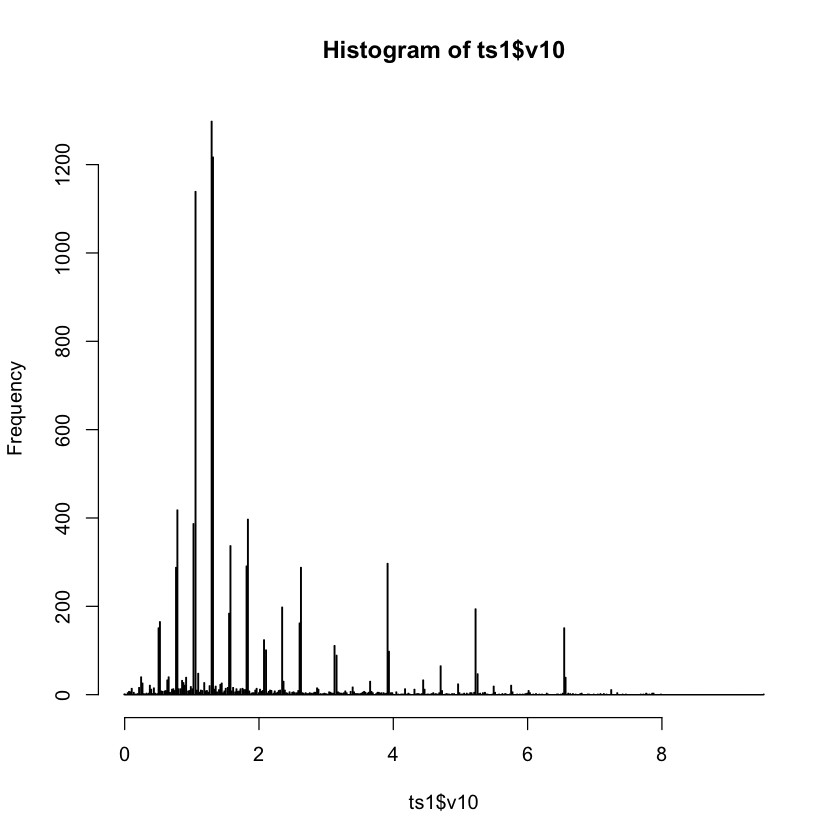

In [24]:
# v10 -- round v10 -- convert to categorical later
hist(ts1$v10, breaks = 1000) # Frequency spikes at pretty even intervals, so can round the values to the nearest spike and turn into a categorical
set(ts1, j="v10", value=round(ts1[,v10]/0.0218818357511,0)) # posted by raddar in the forums

In [25]:
excludeCols <- c("ID","target","filter","dummy","pred0")
varCols <- setdiff(colnames(ts1), excludeCols)

#### Create missingness table
If you look at the data you will see that rows have similar missingness patterns so we can create a feature
that groups together rows with similar missingness patterns. This will better help the GBM split the data.

In [26]:
charCols <- which(sapply(ts1[,-excludeCols,with=FALSE], is.character))
ts1_miss <- copy(ts1[,-excludeCols,with=FALSE])
for (col in charCols){
  set(ts1_miss, j=col, value=as.numeric(as.factor(ts1_miss[[col]])))
}
ts1_miss[!is.na(ts1_miss)] <- 0
ts1_miss[is.na(ts1_miss)] <- 1
colnames(ts1_miss) <- paste0(colnames(ts1_miss),"_NA")

In [ ]:
#### Plot a missingness map

Warning message in if (class(obj) == "amelia") {:
“the condition has length > 1 and only the first element will be used”

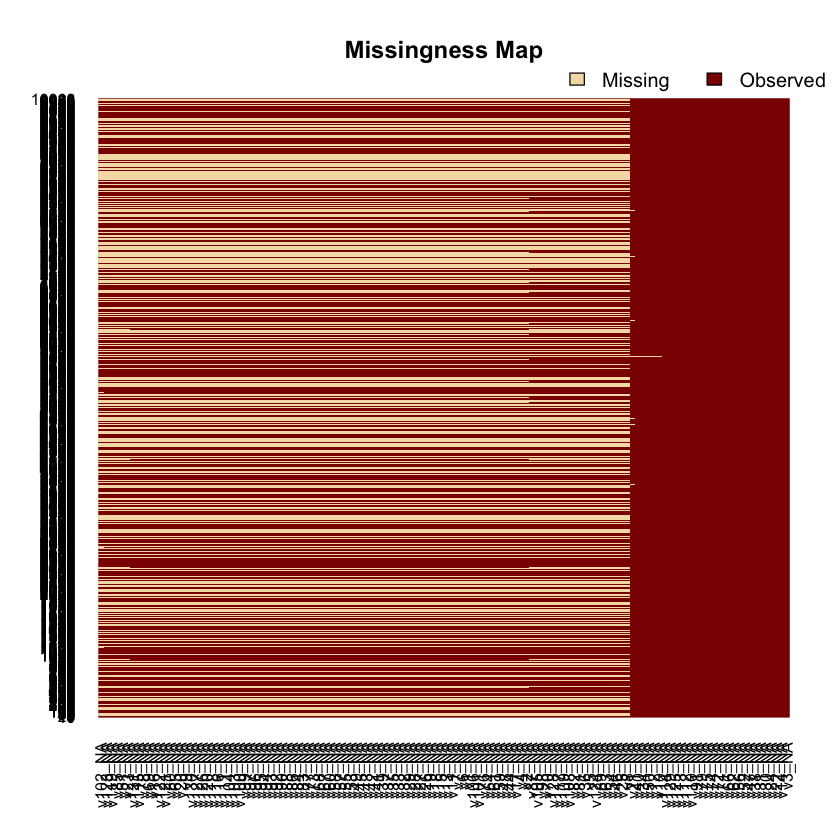

In [27]:
ts1_miss[ts1_miss==1] <- NA #convert 1's to NAs for missingness map plot
missmap(ts1_miss)
ts1_miss[is.na(ts1_miss)] <- 1 #convert NAs back to 1

#### K-Means Cluster on missingness
This will allow us to create a few distinct groups based on missingness

In [28]:
set.seed(104)
ts1_kmeans7 <- kmeans(ts1_miss, centers=7, iter.max=50, nstart=5)
km_y_summ7 <- data.table(target=ts1$target, cluster=ts1_kmeans7$cluster, filter=ts1$filter)
km7 <- km_y_summ7[filter==0][,list(meanTarget=mean(target)), keyby=cluster] 
km_y_summ7 <- merge(km_y_summ7, km7, by="cluster")
ts1$km7 <- as.factor(make.names(km_y_summ7$cluster))

#### ROW SUMMARY VARIABLES
These find the max, min, mean, etc. values of the numeric columns for each row. 
Also count the number of NAs and 0's.

In [29]:
# Identify the numeric columns
numCols <- names(which(sapply(ts1[,varCols,with=FALSE], is.numeric)))
## Add row summary variables
ts1$rowMax <- apply(ts1[, numCols, with=FALSE], 1, max) 
ts1$rowMin <- apply(ts1[, numCols, with=FALSE], 1, min) 
ts1$rowMean <- apply(ts1[, numCols, with=FALSE], 1, mean)
ts1$rowMed <- apply(ts1[, numCols, with=FALSE], 1, median)
ts1$rowSD <- apply(ts1[, numCols, with=FALSE], 1, sd)
## Count NAs by row
ts1$cntNA <- rowSums(is.na(ts1[, varCols, with=FALSE]))
ts1$cntZero <- rowSums(ts1[, varCols, with=FALSE] == 0, na.rm=TRUE)
## Round numeric values -- This can sometimes help when a measurement is too granular
for (col in numCols){
    set(ts1, j=col, value=round(ts1[[col]], 4))
}
#head(ts1[,(numCols) := round(.SD,4), .SDcols=numCols],25)
## Give blank factor levels a name -- just personal preference
charCols <- colnames(ts1)[sapply(ts1, is.character)]
for (col in 1:length(charCols)){
  set(ts1, i=which(is.na(ts1[[charCols[col]]])), j=charCols[col], value="NULL")
}

#### Convert character columns to factor

In [30]:
## This will be used later when we dummy code variables
ts1 <- ts1[,(charCols):=lapply(.SD, as.factor),.SDcols=charCols]

## These variables have relatively few unique values compared to the other numeric columns
## Converting these variables to factors ended up helping the model
ts1$v10 <- as.factor(make.names(ts1$v10)) # 323 unique values
ts1$v38 <- as.factor(make.names(ts1$v38)) # 11 unique values
ts1$v62 <- as.factor(make.names(ts1$v62)) # 8 unique values
ts1$v72 <- as.factor(make.names(ts1$v72)) # 13 unique values
ts1$v129 <- as.factor(make.names(ts1$v129)) # 10 unique values

#### NAs and zero-variance features

In [31]:
# Converting NAs to -1. Numerics are greater than 0 so -1 is out of range. 
ts1[is.na(ts1)] <- -1

# Get rid of zero variance variables if there are any
pp <- preProcess(ts1[filter==0, -excludeCols, with=FALSE], method="zv")
ts1 <- predict(pp, ts1)

#### INTERACTION COUNTS AND MEAN ENCODING 
See: http://helios.mm.di.uoa.gr/~rouvas/ssi/sigkdd/sigkdd.vol3.1/barreca.ps

The idea is the encode categoricals (usual those with high cardinality) or interactions by the mean of their response.
However, instead of encoding as their mean, we encode them in a Bayesian manner, using the overall average response
as the prior and the mean response of each categorical value as the posterior. A weighted average of the 
prior and the posterior is used to encode the categorical variable (or interactions). The weight is based
on the frequency of the categorical value (or the frequency of the interaction). I.e. if a category only
appears a handful of times then it will be encoded as the overall mean response of the training set, if a category
occurs very frequently then most the weight will be placed on the posterior average.

##### Numeric interactions

In [32]:
pairs <- combn(c("v35","v21","v12","v50","v14","v40","v114","v34"), 2, simplify=FALSE)
cl <- makeCluster(threads)
registerDoParallel(cl)
set.seed(119)
out <- foreach(i=1:length(pairs), .combine='comb', .multicombine=TRUE,
               .init=list(list(), list()), .packages=c("data.table")) %dorng% {
                 name <- paste0(pairs[[i]][1], "_", pairs[[i]][2], "_int2") 
                 tmp <- ts1[,pairs[[i]][1], with=FALSE] / (ts1[,pairs[[i]][2], with=FALSE] + 1e-05)
                 if (var(tmp[ts1$filter==0]) != 0) # exclude columns with no variance in the training set
                   list(tmp, name)
               }
stopCluster(cl)
pairInts <- as.data.frame(out[[1]])
colnames(pairInts) <- unlist(out[[2]])

ts1 <- cbind(ts1, pairInts)
rm(pairInts); x <- gc() #suppress verbose output

#### Factor 2-way interaction counts & means

In [33]:
factCols <- colnames(ts1[,-excludeCols,with=FALSE])[sapply(ts1[,-excludeCols,with=FALSE], is.factor)]
pairs <- combn(factCols, 2, simplify=FALSE)

cl <- makeCluster(threads)
registerDoParallel(cl)
set.seed(120)
out <- foreach(i=1:length(pairs), .combine='comb', .multicombine=TRUE,
               .init=list(list(), list()), .packages=c("sqldf", "data.table")) %dorng% {
                 name <- paste0(pairs[[i]][1], "_", pairs[[i]][2], "_cnt2") 
                 tmp <- my.f2cnt(ts1, pairs[[i]][1], pairs[[i]][2])
                 if (var(tmp[ts1$filter==0]) != 0) # exclude columns with no variance in the training set
                   list(tmp, name)
               }
stopCluster(cl)
pairCnts <- as.data.frame(out[[1]])
colnames(pairCnts) <- unlist(out[[2]])

ts1 <- cbind(ts1, pairCnts)
rm(pairCnts); x <- gc() #suppress verbose output

# 2-way averages
cl <- makeCluster(threads)
registerDoParallel(cl)
set.seed(121)
out <- foreach(i=1:length(pairs), .combine='comb', .multicombine=TRUE,
               .init=list(list(), list()), .packages=c("sqldf", "data.table","VGAM")) %dorng% {
                 name <- paste0(paste0(pairs[[i]],collapse="_"), "_targetMean2way")
                 tmp <- catNWayAvgCV(data = ts1, pairs[[i]], 
                                     y = "target",pred0 = "pred0",
                                     filter = ts1$filter==0, k = 20, f = 10, r_k = 0.04, cv=cvFoldsList)
                 tmp <- logit(pmin(pmax(tmp, 1e-15), 1-1e-15))
                 list(tmp, name)
               }
stopCluster(cl)
pairMeans <- as.data.frame(out[[1]])
colnames(pairMeans) <- unlist(out[[2]])


ts1 <- cbind(ts1, pairMeans)
rm(pairMeans); x <- gc() #suppress verbose output

#### Add 3-way interaction counts & means

In [34]:
triplets <- combn(c("v3","v10","v22","v24","v30","v38",
                    "v47","v52", "v56", "v62","v66","v72",
                    "v74","v75","v79", "v91","v110","v112","v113","v125","v129"), 3, simplify=FALSE)
cl <- makeCluster(threads)
registerDoParallel(cl)
set.seed(122)
out <- foreach(i=1:length(triplets), .combine='comb', .multicombine=TRUE,
               .init=list(list(), list()), .packages=c("sqldf", "data.table")) %dorng% {
                 name <- paste0(triplets[[i]][1], "_", triplets[[i]][2],"_",triplets[[i]][3], "_cnt3") 
                 tmp <- my.f3cnt(ts1, triplets[[i]][1], triplets[[i]][2], triplets[[i]][3])
                 if (var(tmp[ts1$filter==0]) != 0)  # exclude columns with no variance in the training set
                   list(tmp, name)
               }
stopCluster(cl)
tripCnts <- as.data.frame(out[[1]])
colnames(tripCnts) <- unlist(out[[2]])

ts1 <- cbind(ts1, tripCnts)
rm(tripCnts); x <- gc() #suppress verbose output

# add v22 to comb2List 
comb2List_v22 <- lapply(comb2List, function(x) c(x,"v22"))
triplets <- c(triplets, comb2List_v22)
# sort vectors and remove duplicates
triplets <- unique(lapply(triplets, function(x) sort(x)))

# triplets <- combn(factCols, 3, simplify=FALSE)
cl <- makeCluster(threads)
registerDoParallel(cl)
set.seed(123)
out <- foreach(i=1:length(triplets), .combine='comb', .multicombine=TRUE,
               .init=list(list(), list()), .packages=c("sqldf", "data.table","VGAM")) %dorng% {
                 name <- paste0(paste0(triplets[[i]],collapse="_"), "_targetMean3way")
                 tmp <- catNWayAvgCV(data = ts1, triplets[[i]], y = "target",pred0 = "pred0",filter = ts1$filter==0, k = 20, f = 10, r_k = 0.04, cv=cvFoldsList)
                 tmp <- logit(pmin(pmax(tmp, 1e-15), 1-1e-15))
                 list(tmp, name)
               }
stopCluster(cl)
tripMeans <- as.data.frame(out[[1]])
colnames(tripMeans) <- unlist(out[[2]])

ts1 <- cbind(ts1, tripMeans)
rm(tripMeans); x <- gc() #suppress verbose output

#### Add 4-way interaction means

In [35]:
quads <- lapply(comb3List, function(x) c(x,"v22"))
cl <- makeCluster(threads)
registerDoParallel(cl)
set.seed(127)
out <- foreach(i=1:length(quads), .combine='comb', .multicombine=TRUE,
               .init=list(list(), list()), .packages=c("sqldf", "data.table","VGAM")) %dorng% {
                 name <- paste0(paste0(quads[[i]],collapse="_"), "_targetMean4way")
                 tmp <- catNWayAvgCV(data = ts1, quads[[i]], 
                                     y = "target",pred0 = "pred0",filter = ts1$filter==0, 
                                     k = 20, f = 10, r_k = 0.04, cv=cvFoldsList)
                 tmp <- logit(pmin(pmax(tmp, 1e-15), 1-1e-15))
                 list(tmp, name)
               }
stopCluster(cl)
quadMeans <- as.data.frame(out[[1]])
colnames(quadMeans) <- unlist(out[[2]])

ts1 <- cbind(ts1, quadMeans)
rm(quadMeans); x <- gc() #suppress verbose output

#### Add 5-way interaction means

In [36]:
quints <- lapply(comb4List, function(x) c(x,"v22"))
cl <- makeCluster(threads)
registerDoParallel(cl)
set.seed(131)
out <- foreach(i=1:length(quints), .combine='comb', .multicombine=TRUE,
               .init=list(list(), list()), .packages=c("sqldf", "data.table","VGAM")) %dorng% {
                 name <- paste0(paste0(quints[[i]],collapse="_"), "_targetMean5way")
                 tmp <- catNWayAvgCV(data = ts1, quints[[i]], y = "target",pred0 = "pred0",filter = ts1$filter==0, k = 20, f = 10, r_k = 0.04, cv=cvFoldsList)
                 tmp <- logit(pmin(pmax(tmp, 1e-15), 1-1e-15))
                 list(tmp, name)
               }
stopCluster(cl)
quintMeans <- as.data.frame(out[[1]])
colnames(quintMeans) <- unlist(out[[2]])

ts1 <- cbind(ts1, quintMeans)
rm(quintMeans); x <- gc() #suppress verbose output

#### Add 7-way interaction means

In [37]:
septups <- combn(c("v22","v10","v24","v47","v52",
                   "v56", "v66","v72", "v74", "v79","v110",
                   "v113","v125","v129"), 7, simplify=FALSE)
cl <- makeCluster(threads)
registerDoParallel(cl)
set.seed(135)
out <- foreach(i=1:length(septups), .combine='comb', .multicombine=TRUE,
               .init=list(list(), list()), .packages=c("sqldf", "data.table","VGAM")) %dorng% {
                 name <- paste0(paste0(septups[[i]],collapse="_"), "_targetMean7way")
                 tmp <- catNWayAvgCV(data = ts1, septups[[i]], y = "target",
                                     pred0 = "pred0",filter = ts1$filter==0, 
                                     k = 20, f = 10, r_k = 0.04, cv=cvFoldsList)
                 tmp <- logit(pmin(pmax(tmp, 1e-15), 1-1e-15))
                 list(tmp, name)
               }
stopCluster(cl)
septupsMeans <- as.data.frame(out[[1]])
colnames(septupsMeans) <- unlist(out[[2]])

ts1 <- cbind(ts1, septupsMeans)
rm(septupsMeans); x <- gc() #suppress verbose output

#### PAIRWISE CORRELATIONS (GOLDEN FEATURES) 
-- code & idea from Tian Zhou - teammate in Homesite competition

The idea of this next section is to identify highly correlated variables and then create a new feature
for each pair which is the difference between them. This results in new features which is basically an
indiator of when two columns differ.

Next cell can be skipped for sake of time saving

In [38]:
numCols <- colnames(ts1[,-excludeCols,with=FALSE])[sapply(ts1[,-excludeCols,with=FALSE], is.numeric)] # will need this later
featCor <- cor(ts1[,numCols,with=FALSE])
hc <- findCorrelation(featCor, cutoff=0.997 ,names=TRUE)  # find highly correlated variables
hc <- sort(hc)
write.csv(hc, "./data_trans/hc.csv", row.names=F)
save(featCor, file="./data_trans/featCor_v31.rda")

featCorDF <- abs(featCor[!rownames(featCor) %in% hc, !colnames(featCor) %in% hc])
featCorDF[upper.tri(featCorDF, diag=TRUE)] <- NA
featCorDF <- melt(featCorDF, varnames = c('V1','V2'), na.rm=TRUE)
featCorDF <- featCorDF[order(featCorDF$value, decreasing=TRUE),]


goldFeats <- 300
feat_gold <- gold_features(featCorDF, goldFeats)
write.csv(as.character(featCorDF$V2[1:goldFeats]), file = "./data_trans/goldFeatNames.csv",row.names=FALSE)

# Do not parallelize -- too much memory for some reason
cl <- makeCluster(1)
registerDoParallel(cl)
set.seed(136)
out <- foreach(i=1:length(feat_gold), .combine='comb', .multicombine=TRUE,
               .init=list(list(), list()), .packages=c("data.table")) %dorng% {
                 name <- paste0(feat_gold[[i]][[1]],"_",feat_gold[[i]][[2]],"_cor")
                 tmp <- ts1[,as.character(feat_gold[[i]][[1]]), with=FALSE] - ts1[,as.character(feat_gold[[i]][[2]]), with=FALSE]
                 list(tmp, name)
               }
stopCluster(cl)
goldMeans <- as.data.frame(out[[1]])
colnames(goldMeans) <- unlist(out[[2]])
write.csv(goldMeans, "./data_trans/goldMeans.csv")

In [39]:
## Since featCor takes awhile to calculate, we'll import a previously run version to save time
goldMeans <- fread("./data_trans/goldMeans.csv")
ts1 <- cbind(ts1, goldMeans)
rm(goldMeans)
x <- gc() #suppress verbose output

goldFeats <- 100
feat_gold <- gold_featuresUnCor(featCorDF, goldFeats)

# Do not parallelize -- too much memory for some reason
cl <- makeCluster(1)
registerDoParallel(cl)
set.seed(136)
out <- foreach(i=1:length(feat_gold), .combine='comb', .multicombine=TRUE,
               .init=list(list(), list()), .packages=c("data.table")) %dorng% {
                 name <- paste0(feat_gold[[i]][[1]],"_",feat_gold[[i]][[2]],"_corAdd")
                 tmp <- ts1[,as.character(feat_gold[[i]][[1]]), with=FALSE] + ts1[,as.character(feat_gold[[i]][[2]]), with=FALSE]
                 list(tmp, name)
               }
stopCluster(cl)
goldAdds <- as.data.frame(out[[1]])
colnames(goldAdds) <- unlist(out[[2]])
write.csv(goldAdds, "./data_trans/goldAdds.csv")

## Since featCor takes awhile to calculate, we'll import a previously run version to save time
goldAdds <- fread("./data_trans/goldAdds.csv")
ts1 <- cbind(ts1, goldAdds)
rm(goldAdds)
x <- gc() #suppress verbose output

hc <- fread("./data_trans/hc.csv")
goldFeatNames <- fread("./data_trans/goldFeatNames.csv")
if (length(c(hc$x,goldFeatNames$x)>0))
  ts1 <- ts1[,-c(hc$x,goldFeatNames$x),with=FALSE]
######################################################

#### HELPER COLUMNS
The idea is to identify columns for each class that will help differentiate that class from the other classes
These columns are then added together to create a new feature that will hopefully improve the model
Only numeric columns can be used (can convert categoricals to dummy or mean encodings)
Numeric columns need to be centered and scaled before choosing features.

In [40]:
# Scale variables so a few don't overpower the helper columns
pp <- preProcess(ts1[filter==0,-excludeCols,with=FALSE], method=c("zv","center","scale","medianImpute"))
ts1 <- predict(pp, ts1)

# summ <- as.data.frame(ts1[ts1$filter==0, colnames(ts1) %in% c("target",numCols),with=FALSE] %>% group_by(target) %>%
#                         summarise_each(funs(mean)))
cols <- c("target",numCols)
summ <- ts1[filter==0, colnames(ts1) %in% cols, with=FALSE][,lapply(.SD, mean) , by=target]

# Find means and sd's for columns
mn1 <- sapply(summ[,2:ncol(summ),with=F], mean)
sd1 <- sapply(summ[,2:ncol(summ),with=F], sd)
# Find upper and lower thresholds
hi <- mn1+2*sd1
lo <- mn1-2*sd1

helpCols <- list()
for (i in 0:1){
  tmpHi <- (summ[summ$target==i,2:ncol(summ),with=F] - mn1)/sd1
  hiNames <- colnames(tmpHi[,order(tmpHi),with=F][,1:30,with=F])
  loNames <- colnames(tmpHi[,order(tmpHi,decreasing = TRUE), with=F][,1:30,with=F])
  
  helpCols[[i+1]] <- c(hiNames, loNames)
  
}
names(helpCols) <- paste0("X", seq_along(helpCols)-1)

for (i in 0:1){
  ts1[[ncol(ts1)+1]] <- rowSums(ts1[,helpCols[[i+1]], with=FALSE])
  colnames(ts1)[ncol(ts1)] <- paste0("X", i, "_helper")}

#### Create summary variables for high-dimensional factors

In [41]:
factorCols <- colnames(ts1)[sapply(ts1, is.factor)]
highCardFacts <- colnames(ts1[,factorCols,with=FALSE])[sapply(ts1[,factorCols,with=FALSE], function(x) length(unique(x))>30)]

for(ii in highCardFacts) {
  print(ii)
  x <- data.frame(x1=ts1[, ii,with=FALSE])
  x[,ii] <- as.numeric(x[,ii])
  ts1[, paste(ii, "_num", sep="")] <- x
}


for(ii in highCardFacts) {
  print(ii)
  x <- data.table(x1=ts1[, ii,with=FALSE])
  colnames(x) <- "x1"
  x$x1 <- as.numeric(x$x1)
  sum1 <- x[, list(cnt=.N), by=x1]
  tmp <- merge(x, sum1, by="x1", all.x=T)
  ts1[, paste(ii, "_cnt", sep="")] <- tmp$cnt
}

# Replace high cardinality factors with target mean
for(ii in highCardFacts) {
  name <- paste0(ii, "_targetMean")
  ts1[,name] <- catNWayAvgCV(data = ts1, c(ii, "dummy"), y = "target",pred0 = "pred0",filter = ts1$filter==0, k = 20, f = 10, r_k = 0.04, cv=cvFoldsList)
}

# Remove high cardinality factors now that we've encoded them
ts1 <- ts1[,!colnames(ts1) %in% highCardFacts,with=FALSE]

[1] "v10"
[1] "v22"
[1] "v56"
[1] "v113"
[1] "v125"
[1] "v10"
[1] "v22"
[1] "v56"
[1] "v113"
[1] "v125"


Warning message in alloc.col(x):
“Attempt to reduce allocation from 1029 to 1028 ignored. Can only increase allocation via shallow copy. Please do not use DT[...]<- or DT$someCol<-. Use := inside DT[...] instead.”Warning message in alloc.col(x):
“Attempt to reduce allocation from 1029 to 1028 ignored. Can only increase allocation via shallow copy. Please do not use DT[...]<- or DT$someCol<-. Use := inside DT[...] instead.”Warning message in alloc.col(x):
“Attempt to reduce allocation from 1029 to 1028 ignored. Can only increase allocation via shallow copy. Please do not use DT[...]<- or DT$someCol<-. Use := inside DT[...] instead.”Warning message in alloc.col(x):
“Attempt to reduce allocation from 1029 to 1028 ignored. Can only increase allocation via shallow copy. Please do not use DT[...]<- or DT$someCol<-. Use := inside DT[...] instead.”Warning message in alloc.col(x):
“Attempt to reduce allocation from 1029 to 1028 ignored. Can only increase allocation via shallow copy. Please do n

#### Create dummy variables for low-dimensional factors

In [42]:
factorCols <- colnames(ts1[,-excludeCols,with=FALSE])[sapply(ts1[,-excludeCols,with=FALSE], is.factor)]
ts1_dum <- as.data.table(model.matrix(~ ., data=ts1[,factorCols,with=FALSE] ))[,-1,with=FALSE]
# remove factor cols
ts1 <- ts1[,-factorCols, with=F]
ts1 <- cbind(ts1, ts1_dum)

#### Write CSV file

In [43]:
ts1 <- ts1[order(ts1$filter, ts1$ID),]
write.csv(ts1, "./data_trans/ts2Trans_v31.csv", row.names=FALSE)

In [44]:
# Even with row sampling running the final model can take a bit of time
# Load in a prerun model on the subsampled dataset
load("./stack_models/xgb46cv.rda")

In [45]:
min(xgb46cv$dt$test.logloss.mean)

[1] 0.463343

In [46]:
# Model run on the entire training set -- takes a few hours to train
# Load in a prerun model on the entire train set
load("./stack_models/xgb46cv_fulldata.rda")

In [47]:
min(xgb46cv$evaluation_log$test_logloss_mean) #different format because this model was trained with different xgboost version

[1] 0.430885